# SiamMAE

In [1]:
import torch
from mae.models_mae import  mae_vit_base_patch16

In [2]:
from dataset_loader.dataset import get_kinetics_dataset, unnormalize_for_plot, unnormalize

/home/eele/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    
print("Using device =", device)

Using device = cuda


In [4]:
data = get_kinetics_dataset("./dataset/")

Loading dataset from ./dataset/
min_gap: 2, max_gap: 10, temporal_dim: -3, repeated_sampling: 1


In [5]:
print(data.num_videos)

711


In [6]:
BATCH_SIZE = 8

data_loader = torch.utils.data.DataLoader(
    data,
    batch_size=BATCH_SIZE,
)

torch.Size([8, 2, 3, 224, 224])


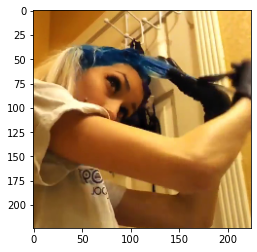

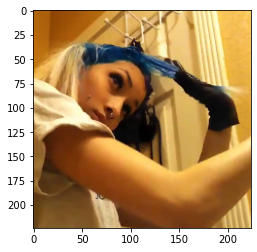

In [7]:
# torch.Size([3, 3, 224, 224])
from dataset_loader.dataset import unnormalize


for batch in data_loader:
    print(batch["video"].shape)
    # torch.Size([8, 4, 3, 224, 224])
    # [BATCH_SIZE x Frames x Channel x Height x Width ]

    import matplotlib.pyplot as plt
    for i in range(batch["video"].shape[1]):
        plt.imshow(unnormalize_for_plot(batch["video"][0][:][i]))
        plt.show()
    break

In [8]:
mae_model = mae_vit_base_patch16().to(device)
mae_model2 = mae_vit_base_patch16().to(device)

In [9]:
# "We use the ViT-S/16 model for most of our experiments as it is similar to ResNet-50 in
# terms of the number of parameters (21M vs 23M) and allows for fair comparisons across different
# self-supervised learning and correspondence learning methods."

In [10]:
# A cross decoder consists of decoder blocks with only cross-attention layers, where tokens from f2
# attend to the tokens from f1.
class CrossDecoder(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossDecoder, self).__init__()
        self.multihead_attn = torch.nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, f1, f2):
        # f1: ([BATCH_SIZE, 196, N])
        # f2: ([BATCH_SIZE, 50, N])

        # Reshape f1 and f2 to fit the input shape requirement of MultiheadAttention
        # which is (seq_len, batch_size, embed_dim)
        f1 = f1.transpose(0, 1)
        f2 = f2.transpose(0, 1)

        # MultiheadAttention takes in the query, key, value. Here we use f2 to attend to f1
        attn_output, _ = self.multihead_attn(f2, f1, f1)

        # Reshape the output back to the original shape
        attn_output = attn_output.transpose(0, 1)

        return attn_output

In [11]:
class SiamMAE(torch.nn.Module):
    def __init__(self, mae, mae2):
        super().__init__()
        self.mae = mae
        self.mae2 = mae2
        self.cross_decoder = CrossDecoder(embed_dim=768, num_heads=12).to(device)

    def forward(self, x):
        frame_one = x[:, 0, :, :, :]
        # * Currently we assume that we take the next frame always. 
        # * This could be improved
        frame_rest = x[:, 1, :, :, :]

        frame_one_x, _frame_one_mask, frame_one_ids = self.mae.forward_encoder(frame_one, mask_ratio = 0)
        frame_one_x = frame_one_x[:, 1:, :]

        frame_rest_x, frame_rest_mask, frame_rest_ids = self.mae2.forward_encoder(frame_rest, mask_ratio = 0.75)

        cross_decoded = self.cross_decoder(frame_one_x, frame_rest_x)

        pred = self.mae2.forward_decoder(cross_decoded, frame_rest_ids)
        loss = self.mae2.forward_loss(frame_rest, pred, frame_rest_mask)
        return loss, pred, frame_rest_mask


In [13]:
from datetime import datetime
from tqdm import tqdm
import os 

def train_one_epoch(epoch_index, data_loader, optimizer, criterion, device, model):
    losses = []
    for i, batch in tqdm(enumerate(data_loader)):
        batch = batch["video"].to(device)
        optimizer.zero_grad()
        output = model(batch)[0]
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

EPOCHS = 60 
now = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

file_to_store_losses_path = f"./losses/{now}.txt" 

folder_to_store_checkpoints = f"./checkpoints/{now}"
os.makedirs(folder_to_store_checkpoints, exist_ok=True)

model = SiamMAE(mae_model, mae_model2).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.MSELoss()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")

    model.train()
    losses = train_one_epoch(epoch, data_loader, optim, loss, device, model)

    avg_loss = sum(losses)/len(losses)
    print(f"Avg Loss: {avg_loss}")

    with open(file_to_store_losses_path, "a") as f:
        f.write(f"Epoch {epoch+1} - Avg Loss: {avg_loss} Losses - {losses} \n")

    # save checkpoint of model after each epoch in folder_to_store_checkpoints/{epoch_number}.pt
    if (epoch+1) % 10 == 0:
    # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
        }, f"{folder_to_store_checkpoints}/{epoch+1}.pt")

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40


KeyboardInterrupt: 

torch.Size([8, 196, 768])
torch.Size([8, 3, 224, 224])


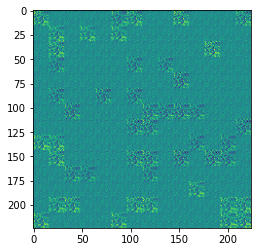

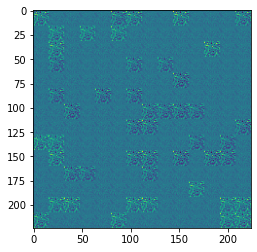

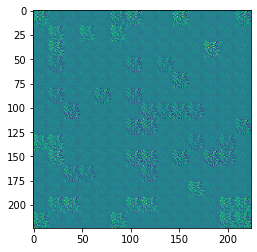

In [ ]:
sample = next(iter(data_loader))
sample["video"]

model.eval()
with torch.no_grad():
    my_pred = model(sample["video"].to(device))[1]
    print(my_pred.shape)
    unpatched_pred = model.mae2.unpatchify(my_pred)
    print(unpatched_pred.shape)

    for i in range(unpatched_pred.shape[1]):
        plt.imshow(unpatched_pred[0][i].to("cpu").numpy())
        plt.show()
    